In [13]:
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from transformers import BertTokenizer
from utils import NERTagger, get_dataloader
from model import CustomBERT

device = torch.device('cuda')


def set_seed(seed=42):
    """
    랜덤 시드 고정
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # GPU 사용 시에도 시드 고정

    # CUDNN 설정 (연산 속도 vs 재현성 선택)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # torch.use_deterministic_algorithms(True)  # 강제적으로 비결정적 연산 금지
    torch.backends.cuda.enable_flash_sdp(False)  # Flash Attention 비활성화
    torch.backends.cuda.enable_math_sdp(True)   # 수학적으로 빠른 비결정적 구현 비활성화
    torch.backends.cuda.enable_mem_efficient_sdp(True)  # 메모리 효율적 SDPA 비활성화


In [14]:
def remove_all_dropout(model):
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = 0.0
            module.training = False  # 만약 Dropout이 eval() 상태가 아닐 수도 있어서
            # print("✅ Dropout found → set to 0.0")

In [22]:
set_seed(0)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MODEL_SAVE_PATH1 = f"toxigen/baseline"
MODEL_SAVE_PATH2 = f"toxigen/3"

model_sts = CustomBERT("bert-base-uncased", hidden_dim=768)
model_hate = CustomBERT("bert-base-uncased", hidden_dim=768)
model_sts.load_state_dict(torch.load(f"./save/{MODEL_SAVE_PATH1}/best_model.pth"))
model_hate.load_state_dict(torch.load(f"./save/{MODEL_SAVE_PATH2}/best_model.pth"))
linear_layer = nn.Linear(768, 10).to(device)

# remove_all_dropout(model_sts)
# remove_all_dropout(model_hate)

linear_layer.eval()
model_sts.eval()
model_hate.eval()
linear_layer.to(device)
model_sts.to(device)
model_hate.to(device)

/tmp/ipykernel_23123/3249853907.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_sts.load_state_dict(torch.load(f"./save/{MODEL_SAVE_PATH1}/best_model.pth"))
/tmp/i

CustomBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [23]:
# # 모든 서브모듈에도 적용됐는지 확인
# for m in model_hate.modules():
#     if isinstance(m, nn.Dropout):
#         print("Dropout rate:", m.p, "| Training mode:", m.training)  # training == False 여야 함


In [16]:
sentence_1 = "white men built america . western civilization is the best"
sentence_2 = "the entire movie is about a boring , sad man being boring and sad"

In [5]:
# from transformers import BertTokenizer

# # BERT Tokenizer 불러오기
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# # 토큰화 수행
# tokens = tokenizer.tokenize(sentence_2)
# input_ids = tokenizer(sentence_1, return_tensors="pt")["input_ids"]

# # 토큰 및 인덱스 출력
# print("Tokens:", tokens)
# print("Token IDs:", input_ids.numpy())


In [58]:
def check_logits(sentence, model):
    # 토크나이징 및 입력 변환
    inputs = tokenizer.encode(sentence, truncation=True, padding="max_length", max_length=512, return_attention_mask=True)
    # inputs2 = tokenizer(sentence_2, return_tensors="pt", padding=True, truncation=True)

    # 모델 실행 (Attention 확인)
    with torch.no_grad():
        outputs = model.bert(torch.tensor([inputs]).to(device))
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰 임베딩

        head_attention_output = model.head_attention(cls_embedding, cls_embedding)
        final_embedding = cls_embedding + head_attention_output  # Head-Attention 결합
        
        final_output = linear_layer(final_embedding)

    # Attention 값 출력
    print(f"logits:\n", final_output.cpu().numpy())
    return final_output


In [34]:
logit1 = check_logits(sentence_1, model_sts)

logits:
 [[ 0.5486511   0.35509002 -0.33489728 -0.11769153  0.3012528  -0.0514281
  -0.02181514  0.17180249  0.36664099 -0.09823436]]


In [25]:
logit2 = check_logits(sentence_1, model_hate)

logits:
 [[ 0.67484915 -0.01338078 -0.3735042   0.3435948  -0.05989319  0.04873056
   0.16585305 -0.01401971  0.6216573  -0.5548622 ]]


In [55]:
logit1_1 = check_logits(sentence_1, model_sts)

logits:
 [[ 0.5605654   0.42956245 -0.41416806 -0.21507911  0.09444287 -0.11559311
  -0.10746312  0.14669016 -0.05945953 -0.2941744 ]]


In [57]:
logit1_2 = check_logits(sentence_1, model_sts)

logits:
 [[-0.03937142 -0.09088795  0.07514546  0.11913416  0.17402574  0.02875124
   0.10788624  0.04790134  0.4411277   0.22268581]]


In [59]:
logit1_3 = check_logits(sentence_1, model_sts)

logits:
 [[ 0.5486511   0.35509002 -0.33489728 -0.11769153  0.3012528  -0.0514281
  -0.02181514  0.17180249  0.36664099 -0.09823436]]


In [ ]:
logit3 = check_logits(sentence_2, model_sts)

In [ ]:
logit4 = check_logits(sentence_2, model_hate)

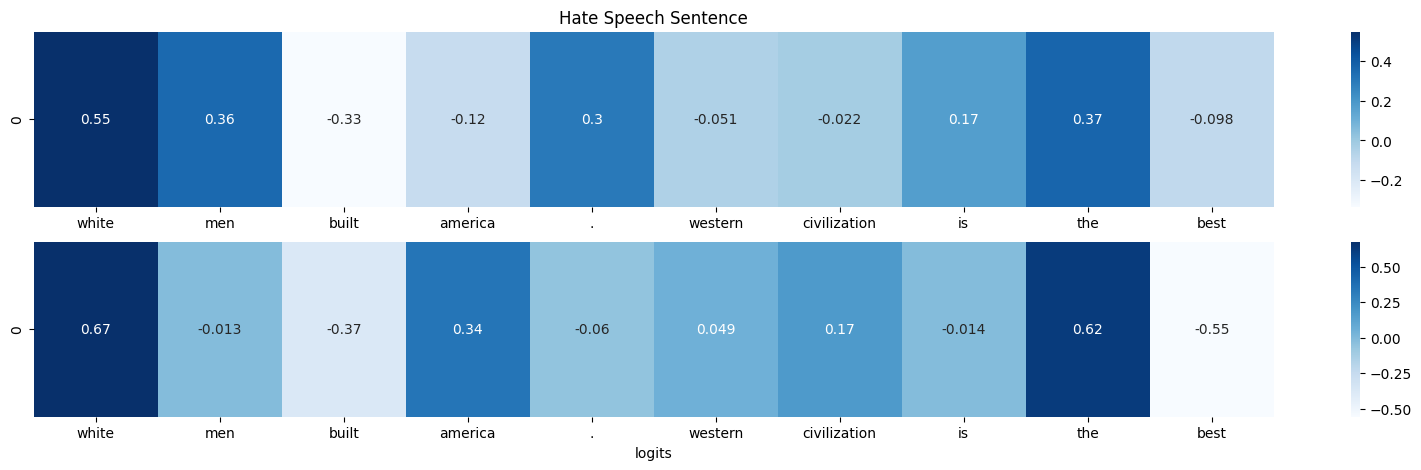

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Attention 값 변환
attention_weights_np1 = logit1.squeeze(-1).cpu().numpy()
attention_weights_np2 = logit2.squeeze(-1).cpu().numpy()

tokens = ['white', 'men', 'built', 'america', '.', 'western', 'civilization', 'is', 'the', 'best']

plt.figure(figsize=(20, 5))

# 시각화
plt.subplot(2, 1, 1)
sns.heatmap(attention_weights_np1, annot=True, cmap="Blues", xticklabels=tokens)
plt.title(f"Hate Speech Sentence")
plt.subplot(2, 1, 2)
sns.heatmap(attention_weights_np2, annot=True, cmap="Blues", xticklabels=tokens)
plt.xlabel("logits")
plt.show()


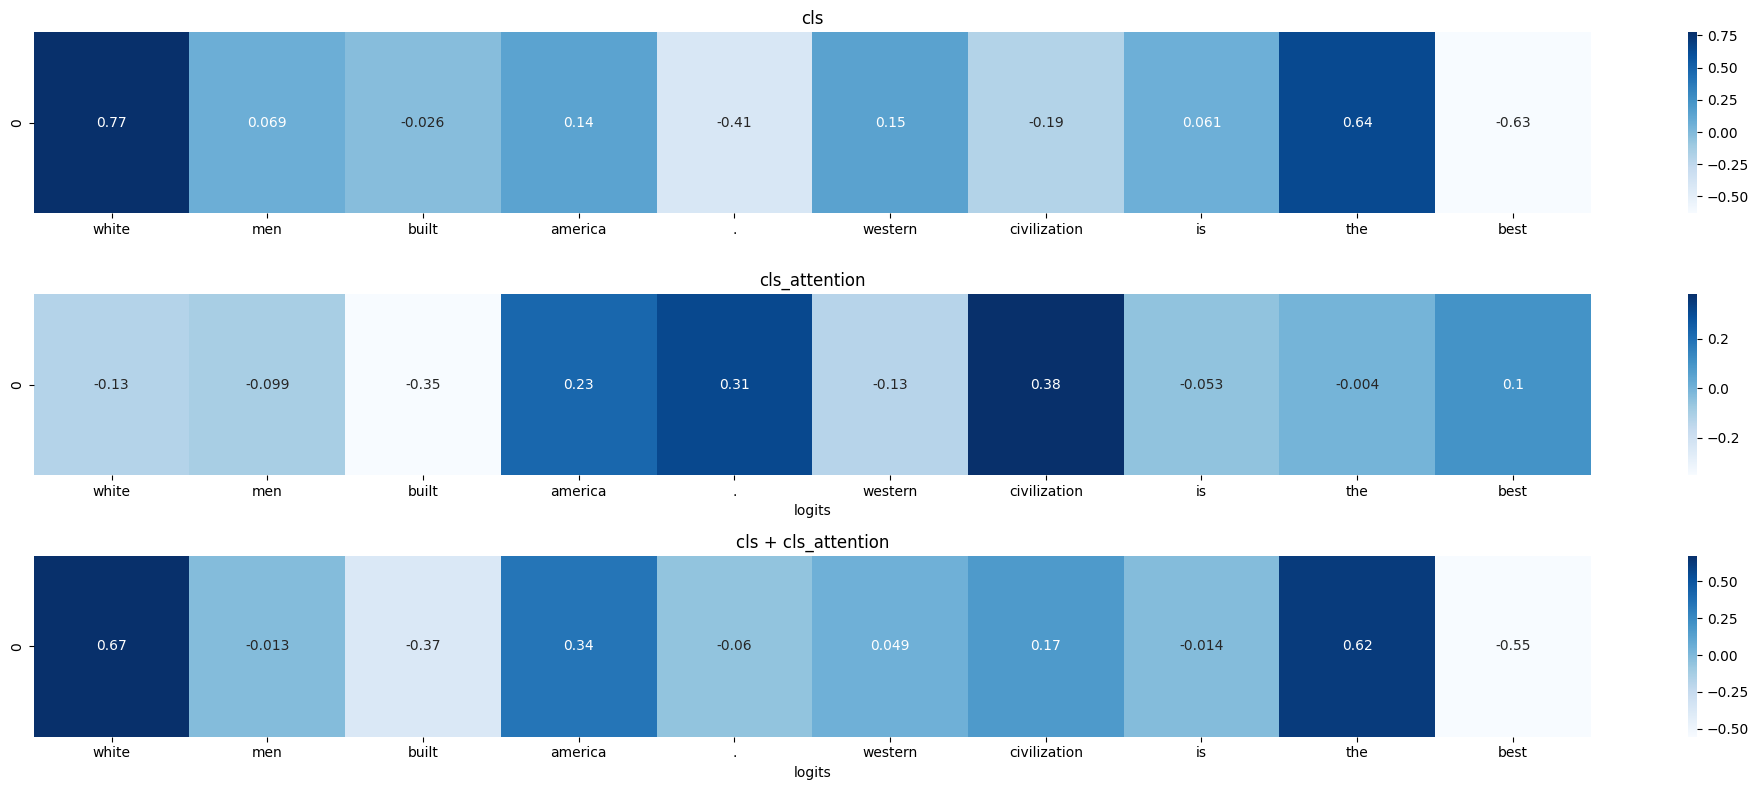

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Attention 값 변환
attention_weights_np1 = logit1_1.squeeze(-1).cpu().numpy()
attention_weights_np2 = logit1_2.squeeze(-1).cpu().numpy()
attention_weights_np3 = logit1_3.squeeze(-1).cpu().numpy()

tokens = ['white', 'men', 'built', 'america', '.', 'western', 'civilization', 'is', 'the', 'best']

plt.figure(figsize=(20, 8))

# 시각화
plt.subplot(3, 1, 1)
sns.heatmap(attention_weights_np1, annot=True, cmap="Blues", xticklabels=tokens)
plt.title(f"cls")
plt.subplot(3, 1, 2)
sns.heatmap(attention_weights_np2, annot=True, cmap="Blues", xticklabels=tokens)
plt.xlabel("logits")
plt.title(f"cls_attention")
plt.subplot(3, 1, 3)
sns.heatmap(attention_weights_np3, annot=True, cmap="Blues", xticklabels=tokens)
plt.xlabel("logits")
plt.title(f"cls + cls_attention")

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Attention 값 변환
attention_weights_np1 = logit3.squeeze(-1).cpu().numpy()
attention_weights_np2 = logit4.squeeze(-1).cpu().numpy()

tokens = ['the', 'entire', 'movie', 'is', 'about', 'a', 'boring', ',', 'sad', 'man', 'being', 'boring', 'and', 'sad']

plt.figure(figsize=(20, 5))

# 시각화
plt.subplot(2, 1, 1)
sns.heatmap(attention_weights_np1, annot=True, cmap="Blues", xticklabels=tokens)
plt.title(f"Semantic Sentence")
plt.subplot(2, 1, 2)
sns.heatmap(attention_weights_np2, annot=True, cmap="Reds", xticklabels=tokens)
plt.xlabel("logits")

plt.tight_layout()
plt.show()
